**Real-Time Camera Calibration using OpenCV (Logitech C310 HD) – Prabal Sharma**

📸 Hold your PRINTED chessboard in front of the webcam at different angles...


<IPython.core.display.Javascript object>

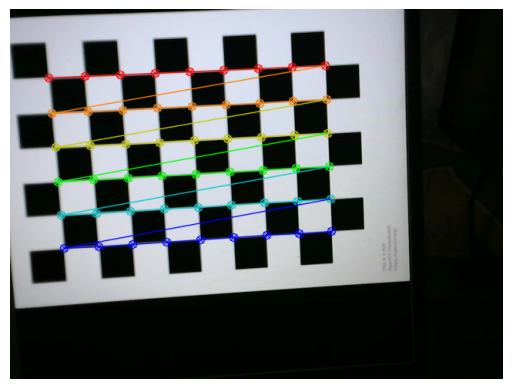

✅ Captured 1/12 images


<IPython.core.display.Javascript object>

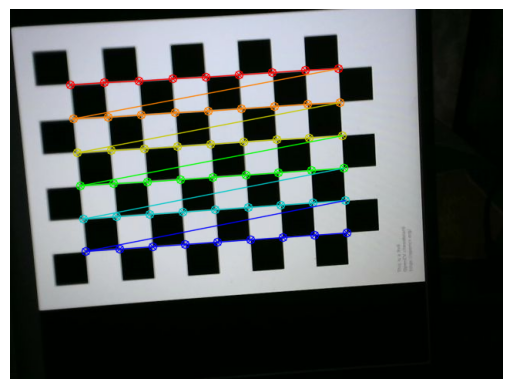

✅ Captured 2/12 images


<IPython.core.display.Javascript object>

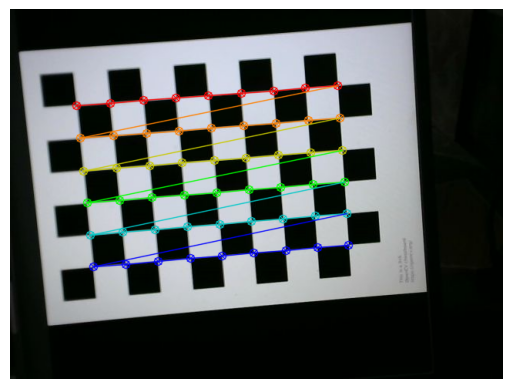

✅ Captured 3/12 images


<IPython.core.display.Javascript object>

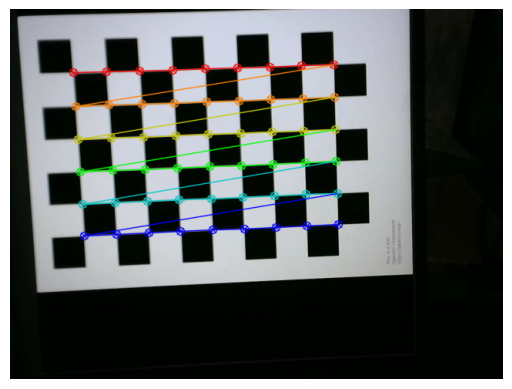

✅ Captured 4/12 images


<IPython.core.display.Javascript object>

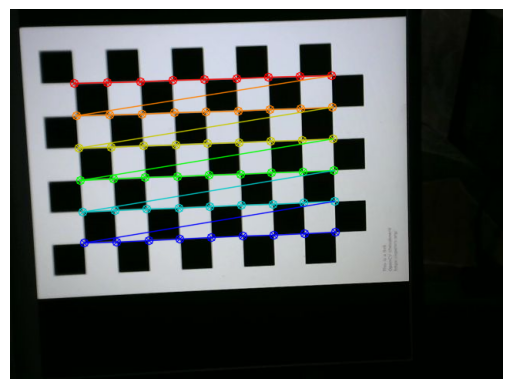

✅ Captured 5/12 images


<IPython.core.display.Javascript object>

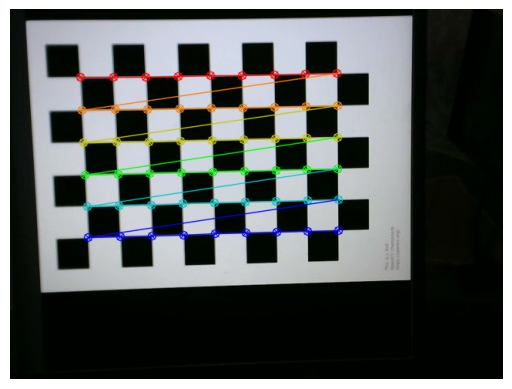

✅ Captured 6/12 images


<IPython.core.display.Javascript object>

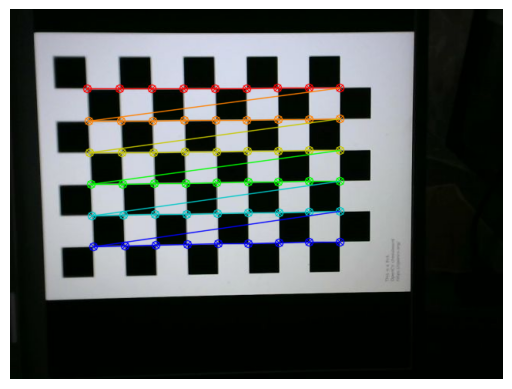

✅ Captured 7/12 images


<IPython.core.display.Javascript object>

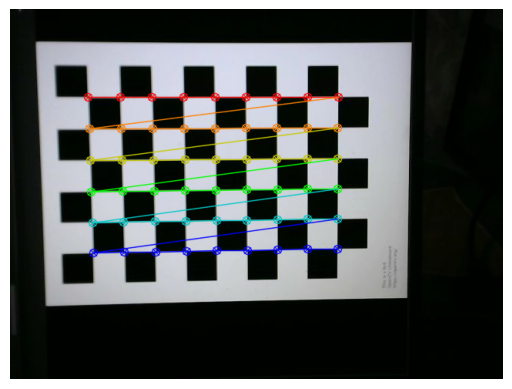

✅ Captured 8/12 images


<IPython.core.display.Javascript object>

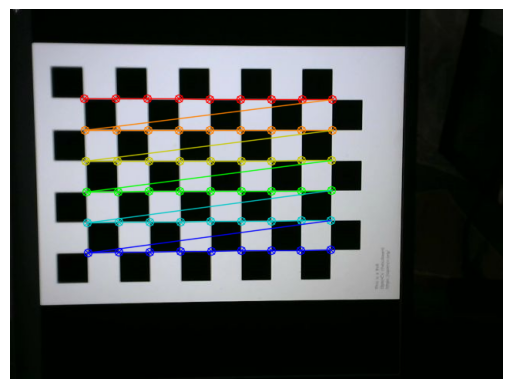

✅ Captured 9/12 images


<IPython.core.display.Javascript object>

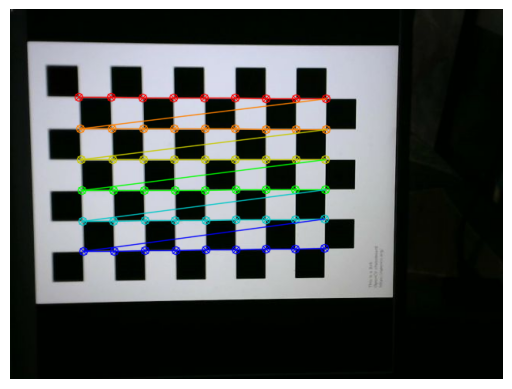

✅ Captured 10/12 images


<IPython.core.display.Javascript object>

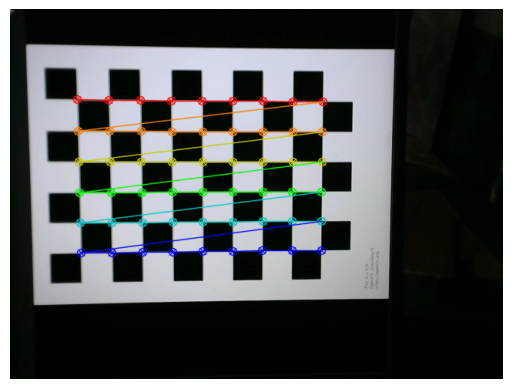

✅ Captured 11/12 images


<IPython.core.display.Javascript object>

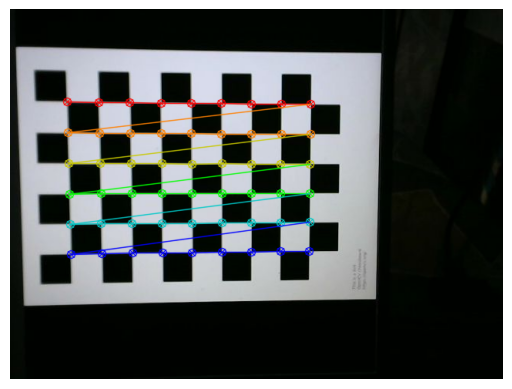

✅ Captured 12/12 images

🎯 Camera Matrix:
 [[1.25240642e+03 0.00000000e+00 3.84245209e+02]
 [0.00000000e+00 1.27087639e+03 1.85754406e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

🎯 Distortion Coefficients:
 [[ 1.69299685e-01 -1.07026418e+00 -9.00815299e-03  4.44746510e-03
   1.42718004e+01]]

📏 Focal Length: fx=1252.41, fy=1270.88
📍 Optical Center: cx=384.25, cy=185.75


In [4]:
# ==========================
# STEP 1: Setup Webcam in Colab (JS + Python bridge)
# ==========================
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import time

def js_capture():
    js = Javascript('''
        async function captureFrame() {
          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Wait a bit to let camera adjust
          await new Promise(resolve => setTimeout(resolve, 1000));

          // Capture one frame
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          video.remove();

          return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    display(js)
    data = eval_js("captureFrame()")
    binary = b64decode(data.split(',')[1])
    return np.array(Image.open(io.BytesIO(binary)))

# ==========================
# STEP 2: Chessboard Settings
# ==========================
chessboard_size = (9, 6)  # inner corners
square_size = 25  # mm (set to your printed chessboard square size)

objp = np.zeros((chessboard_size[0]*chessboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)
objp *= square_size

objpoints = []
imgpoints = []
img_shape = None

# ==========================
# STEP 3: Auto Capture Loop
# ==========================
max_photos = 12  # number of calibration images
count = 0

print("📸 Hold your PRINTED chessboard in front of the webcam at different angles...")

while count < max_photos:
    frame = js_capture()
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    if img_shape is None:
        img_shape = gray.shape[::-1]

    ret, corners = cv2.findChessboardCorners(
        gray, chessboard_size,
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
    )

    if ret:
        corners2 = cv2.cornerSubPix(
            gray, corners, (11,11), (-1,-1),
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        objpoints.append(objp)
        imgpoints.append(corners2)

        cv2.drawChessboardCorners(frame_bgr, chessboard_size, corners2, ret)
        plt.imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        count += 1
        print(f"✅ Captured {count}/{max_photos} images")
        time.sleep(1.0)
    else:
        print("❌ Chessboard not detected, try again (adjust angle/lighting).")

# ==========================
# STEP 4: Calibration
# ==========================
if len(objpoints) > 0:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_shape, None, None
    )

    print("\n🎯 Camera Matrix:\n", mtx)
    print("\n🎯 Distortion Coefficients:\n", dist)

    fx, fy = mtx[0,0], mtx[1,1]
    cx, cy = mtx[0,2], mtx[1,2]

    print(f"\n📏 Focal Length: fx={fx:.2f}, fy={fy:.2f}")
    print(f"📍 Optical Center: cx={cx:.2f}, cy={cy:.2f}")
else:
    print("❌ No valid chessboard images were captured.")
